In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import requests, re, spacy
nlp = spacy.load('en')
import numpy as np
from itertools import product
from bs4 import BeautifulSoup
from collections import defaultdict
from nltk.corpus import stopwords
from IPython.display import HTML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

<h2>Welcome to NLP of the FUTURE(ama)!</h2>
<p>Today, we'll be doing some NLP on the first 5 seasons worth of text from Futurama.  We'll first aquire the data via web scrape, do NLP type cleaning and tokenizing, then compare the Naive Bayes and RF algorythms for classifying if a line was said by Bender Bending Rodriguez.</p>

In [2]:
url_base = "http://www.imsdb.com"
url_stem = "http://www.imsdb.com/TV/Futurama.html"
req = requests.get(url_stem)
soup = BeautifulSoup(req.content, 'html.parser')

<h3>Helper Functions</h3>
<p>Here we define the functions for scraping the data and cleaning the text.  Let's get it running (as it does take a few minutes).</p>

In [3]:
def get_script_soup(script_url):
    '''
    get_script_soup
    
    input: script_url (str) - URL from master link page
    output: BS4 object - The soup object for the script page.
    
    The actual script texts are from a secondary link off of the master link page.
    This is a helper function that takes a script url from the master link page, 
    and goes down two levels to get the script text bs4 object.
    '''
    script_wrapper_soup = BeautifulSoup(requests.get(script_url).content, 'html.parser')
    script_url = script_wrapper_soup\
                    .find_all("table", {"class": "script-details"})[0]\
                    .find_all('a')[-1]\
                    .attrs['href']
    return BeautifulSoup(requests.get(url_base + script_url).content, 'html.parser')

def clean_line(line):
    '''
    clean_line
    
    input: line (str) - a line from the script
    return: list of cleaned, lemetized tokens
    
    This does all the NLP preprocessing:
        * lower text
        * split on special characters, while removing annotations
        * remove stop words
        * perform lemmetization
    '''
    line = line.lower()
    line = [x for x in re.findall(r"[\w()']+", line) if x[0] != "(" and x[-1] != ")"]
    s_stop = set(stopwords.words())
    line = ' '.join([word for word in line if word not in s_stop])
    return [token.lemma_ for token in nlp(line)]

def lines_by_character(script_soup, b_first):
    '''
    lines_by_character
    
    input:
        * script_soup (BS4 object) - The BS4 object of the script text page
        * b_first (bool) - If it's the first episode.  Bender is introduced as "ROBOT",
                            and I hope to preserve as many of his lines as possible.
    return: dict - a dictionary where the key is the character that said it, and the value
                    is the lines in this episode.
    '''
    script_text = script_soup.find_all('td', {"class": "scrtext"})[0].find('body').text.split('\n')
    character = None
    b_actions = False
    d_lines = defaultdict(list)
    cur_line = ''
    for line in [x.strip() for x in script_text if x.strip() != ''][6:]:
        if line == line.upper():
            d_lines[character].append(cur_line)
            cur_line = ""
            character = line
            if b_first == True and character == 'ROBOT':
                character = 'BENDER'
            continue
        if character == None:
            continue
        if line[0] == "[" and line[-1] == "]":
            continue
        if line[0] == "[":
            b_actions = True
        if b_actions == True:
            if line[-1] == "]":
                b_actions = False
            continue
        cur_line += " " + line
    return d_lines

def merge_dols(dol1, dol2):
    ks = set(dol1).union(dol2)
    no = []
    return dict((k, dol1.get(k, no) + dol2.get(k, no)) for k in ks)

def flatten_sublist(l_in):
    return [item for sublist in l_in for item in sublist]

<h3>And here is where I call these functions</h3>

In [4]:
HTML('<img src="images/happy_robot.gif">')

In [5]:
d_all_lines = {}
for td in soup.find_all('td'):
    if td.find('h1') == None or td.find('h1').text != "Futurama Transcripts":
        continue
    for a in td.find('a'):
        if a.title() == '#':
            continue
        for aa in td.find_all('a'):
            print(aa.attrs['title'])
            script_soup = get_script_soup(url_stem + aa.attrs['href'].replace(" ", "%20"))
            d_script_lines = lines_by_character(script_soup, aa.attrs['title']=='Space Pilot 3000 Script')
            d_all_lines = merge_dols(d_all_lines, d_script_lines)

Space Pilot 3000 Script
The Series Has Landed Script
I, Roommate Script
Love's Labours Lost In Space Script
Fear Of A Bot Planet Script
A Fishful Of Dollars Script
My Three Suns Script
A Big Piece Of Garbage Script
Hell Is Other Robots Script
A Flight To Remember Script
Mars University Script
When Aliens Attack Script
Fry And The Slurm Factory Script
I Second That Emotion Script
Brannigan, Begin Again Script
A Head In The Polls Script
Xmas Story Script
Why Must I Be A Crustacean In Love Script
Put Your Head On My Shoulder Script
The Lesser Of Two Evils Script
Raging Bender Script
A Bicyclops Built For Two Script
How Hermes Requisitioned His Groove Back Script
A Clone Of My Own Script
The Deep South Script
Bender Gets Made Script
The Problem With Popplers Script
Mother's Day Script
Anthlogy Of Interest I Script
The Honking Script
War Is The H Word Script
The Cryonic Woman Script
Parasites Lost Script
Amazon Women In The Mood Script
Bendless Love Script
The Day The Earth Stood Stupid Scr

<h2>A (very) Little EDA</h2>
<p>As always we're going to look at what we have now.  I've already done a lot to clean the data, but it's good to look at what we have now.</p>

In [6]:
print(len(d_all_lines.keys()))

963


In [7]:
from collections import Counter
c = Counter(flatten_sublist([clean_line(x) for x in d_all_lines['BENDER']]))
l_tt = list(sorted(filter(lambda x: x[0]!= '-PRON-', c.items()), key=lambda x: x[1], reverse=True))[:10]
for i in range(10):
    print(10-i, l_tt[9-i])
    
c['chumpette']

10 ('like', 120)
9 ("'s", 126)
8 ('hey', 153)
7 ('will', 165)
6 ('do', 170)
5 ('oh', 179)
4 ('go', 187)
3 ('get', 237)
2 ('not', 287)
1 ('be', 825)


1

<h2>Now to create the vectorized dataset</h2>
<p>We now will build a TF-IDF Vectorizer to create data from our text, and create an actual dataset with train-test splits.</p>

In [8]:
HTML('<img src="images/happy_robot.gif">')

In [12]:
#flatten data and label 1 if it comes from bender, 0 otherwise
data = np.array(flatten_sublist([product([1 if k=='BENDER' else 0], v) for k, v in d_all_lines.items()]))

from sklearn.feature_extraction.text import CountVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, analyzer=clean_line)
tfidf = tfidf_vectorizer.fit_transform(data[:, 1])

#count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, analyzer=clean_line)
#tfidf = count_vectorizer.fit_transform(data[:, 1])


X_train, X_test, y_train, y_test = train_test_split(tfidf, data[:, 0],\
                                                    test_size=0.2, random_state=42)

<h2>STOP!!!</h2>
What is wrong in the above cell?

<h2>Head to head algorythms!</h2>
<p>We'll test our newly learned Naive Bayes against a Random Forest</p>

In [13]:
#Naive Bayes with alpha = 1
nb_a1 = MultinomialNB()
nb_a1.fit(X_train, y_train)

#Naive Bayes with alpha = 0.1
nb_ap1 = MultinomialNB(alpha=.1)
nb_ap1.fit(X_train, y_train)

#Naive Bayes with alpha = 0.0001
nb_a0 = MultinomialNB(alpha=0.0001)
nb_a0.fit(X_train, y_train)

#Random Forest with no max depth
#rf_nd = RandomForestClassifier(n_estimators=60)
#rf_nd.fit(X_train, y_train)

#Random Forest with max depth = 10
rf_d10 = RandomForestClassifier(n_estimators=60, max_depth=10)
_ = rf_d10.fit(X_train, y_train)

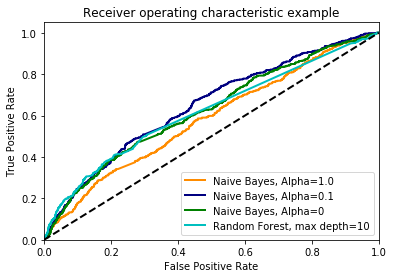

In [14]:
# roc_a1  = roc_curve(y_test, nb_a1.predict_proba(X_test)[:,1], pos_label='1')
# roc_ap1 = roc_curve(y_test, nb_ap1.predict_proba(X_test)[:,1], pos_label='1')
# roc_a0 = roc_curve(y_test, nb_a0.predict_proba(X_test)[:,1], pos_label='1')
#roc_nd = roc_curve(y_test, rf_nd.predict_proba(X_test)[:,1], pos_label='1')
roc_d10 = roc_curve(y_test, rf_d10.predict_proba(X_test)[:,1], pos_label='1')

plt.figure()
lw = 2
plt.plot(roc_a1[0], roc_a1[1], color='darkorange',
         lw=lw, label='Naive Bayes, Alpha=1.0')
plt.plot(roc_ap1[0], roc_ap1[1], color='navy',
         lw=lw, label='Naive Bayes, Alpha=0.1')
plt.plot(roc_a0[0], roc_a0[1], color='g',
         lw=lw, label='Naive Bayes, Alpha=0')
#plt.plot(roc_nd[0], roc_nd[1], color='r',
#         lw=lw, label='Random Forest')
plt.plot(roc_d10[0], roc_d10[1], color='c',
         lw=lw, label='Random Forest, max depth=10')
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()